### TSUNAMI

In [118]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized #, acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [119]:
from fireworks.nbodylib.timesteps import adaptive_timestep_simple, adaptive_timestep_r
from fireworks.nbodylib.integrators import integrator_tsunami

In [120]:
seed(42)

In [121]:
mass1 = 1.
mass2 = 2.
rp = 5. 
e_1 = 0.5               
e_2 = 0.9
e_3 = 0.99

part_1 = ic_two_body(mass1, mass2, rp, e_1)
part_2 = ic_two_body(mass1, mass2, rp, e_2)
part_3 = ic_two_body(mass1, mass2, rp, e_3)

M_tot_1 = np.sum(part_1.mass)
M_tot_2 = np.sum(part_2.mass)
M_tot_3 = np.sum(part_3.mass)

# e = 0.5 
a_1 = rp / (1 - e_1)
P_1 = np.sqrt((4 * np.pi**2. * a_1**3.)/(M_tot_1))
print('P_1 = ', P_1)

# e = 0.9
a_2 = rp / (1 - e_2)
P_2 = np.sqrt((4 * np.pi**2. * a_2**3.)/(M_tot_2))
print('P_2 = ', P_2)

# e = 0.99 
a_3 = rp / (1 - e_3)
P_3 = np.sqrt((4 * np.pi**2. * a_3**3.)/(M_tot_3))
print('P_3 = ', P_3)

P_1 =  114.71474419090953
P_2 =  1282.5498301618645
P_3 =  40557.78675973606


In [122]:
N = 2                       # number of particles
nsteps = 100000            #arbitrary number of timesteps
t = 0
tsimulation_1 = 10*P_1      # end of the simulation for e = 0.5
tsimulation_2 = 10*P_2      # end of the simulation for e = 0.9
tsimulation_3 = 10*P_3      # end of the simulation for e = 0.99
h_1 = (tsimulation_1-t)/nsteps
h_2 = (tsimulation_2-t)/nsteps
h_3 = (tsimulation_3-t)/nsteps
#h_1 = 1
#h_2 = 10
#h_3 = 100
print(h_1, h_2, h_3)    

0.011471474419090954 0.12825498301618646 4.055778675973606


### EULER

In [123]:
part_1_euler_tsunami = part_1.copy()
part_2_euler_tsunami = part_2.copy()
part_3_euler_tsunami = part_3.copy()

In [124]:
r  = part_1_euler_tsunami.radius()
v  = part_1_euler_tsunami.vel_mod()
ts = r/v
ts =  np.nanmin(ts[np.nonzero(ts)])
print(r)
print(v)
print(ts)

[[0.]
 [5.]]
[[0.63245553]
 [0.31622777]]
15.811388300841896


In [125]:
def integration_euler_adaptive(part, h, tsimulation, t, N):
    path_1 = []
    path_2 = []
    time   = []
    time2  = []
    Etot_euler = []
    Ekin_euler = []
    Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_direct_vectorized)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_euler.append(Etot_n)
            Ekin_euler.append(Ekin_n)
            Epot_euler.append(Epot_n)
        
        ts_1 = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    time   = np.array(time)
    time2  = np.array(time2)
    Etot_euler = np.array(Etot_euler)
    Ekin_euler = np.array(Ekin_euler)
    Etot_euler = np.array(Epot_euler)

    return path_1, path_2, Etot_euler, Ekin_euler, Epot_euler, time, time2


In [126]:
# e = 0.5
path1_euler_1_tsunami, path2_euler_1_tsunami, Etot_euler_1_tsunami, Ekin_euler_1_tsunami, Epot_euler_1_tsunami, time_euler_1_tsunami, time2_euler_1_tsunami = integration_euler_adaptive(part_1_euler_tsunami, h_1, tsimulation_1, t, N)
#print(len(time_euler_1_tsunami))

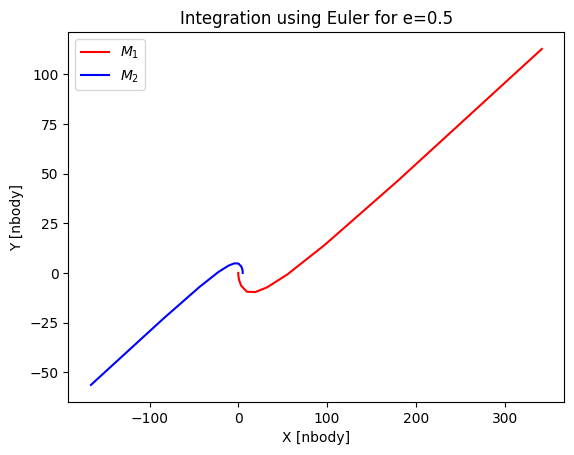

In [127]:
#plt.subplot(1,3,1)
plt.title('Integration using Euler for e=0.5')
plt.plot(path1_euler_1_tsunami[:,0], path1_euler_1_tsunami[:,1], label=f'$M_1$', color='red')
plt.plot(path2_euler_1_tsunami[:,0], path2_euler_1_tsunami[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

Text(0, 0.5, 'timestep tsunami')

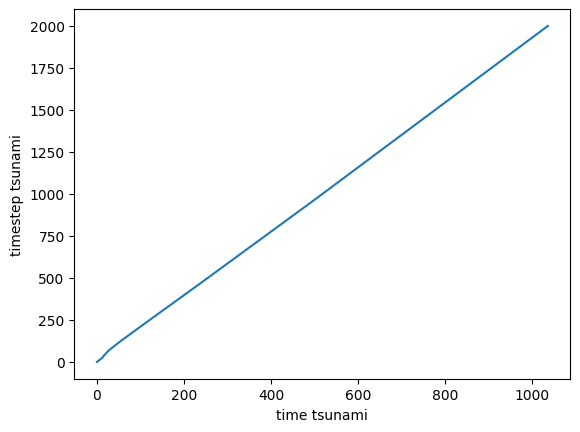

In [137]:
plt.plot(time_euler_1_tsunami, time2_euler_1_tsunami)
plt.xlabel('time tsunami')
plt.ylabel('timestep tsunami')

### LEAPFROG

In [128]:
part_1_leapfrog_tsunami = part_1.copy()
part_2_leapfrog_tsunami = part_2.copy()
part_3_leapfrog_tsunami = part_3.copy()

In [129]:
def integration_leapfrog_adaptive(part, h, tsimulation, t, N):
    path_1 = []
    path_2 = []
    time   = []
    time2  = []
    Etot_leapfrog = []
    Ekin_leapfrog = []
    Epot_leapfrog = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_leapfrog(part, h, acceleration_direct_vectorized)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_leapfrog.append(Etot_n)
            Ekin_leapfrog.append(Ekin_n)
            Epot_leapfrog.append(Epot_n)
        
        ts_1 = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    time   = np.array(time)
    time2  = np.array(time2)
    Etot_leapfrog = np.array(Etot_leapfrog)
    Ekin_leapfrog = np.array(Ekin_leapfrog)
    Etot_leapfrog = np.array(Epot_leapfrog)

    return path_1, path_2, Etot_leapfrog, Ekin_leapfrog, Epot_leapfrog, time, time2


In [130]:
# e = 0.5
path1_leapfrog_1_tsunami, path2_leapfrog_1_tsunami, Etot_leapfrog_1_tsunami, Ekin_leapfrog_1_tsunami, Epot_leapfrog_1_tsunami, time_leapfrog_1_tsunami, time2_leapfrog_1_tsunami = integration_leapfrog_adaptive(part_1_leapfrog_tsunami, h_1, tsimulation_1, t, N)

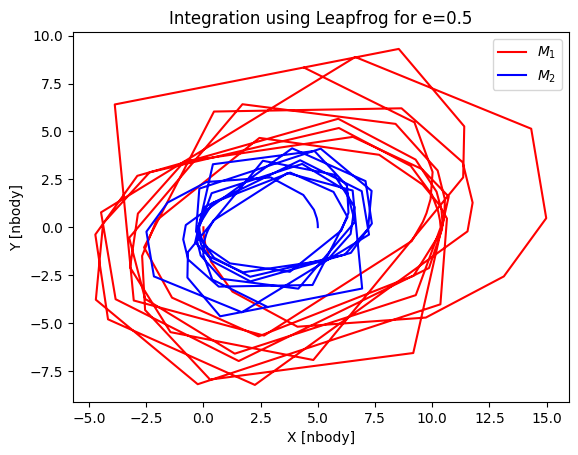

In [131]:
#plt.subplot(1,3,1)
plt.title('Integration using Leapfrog for e=0.5')
plt.plot(path1_leapfrog_1_tsunami[:,0], path1_leapfrog_1_tsunami[:,1], label=f'$M_1$', color='red')
plt.plot(path2_leapfrog_1_tsunami[:,0], path2_leapfrog_1_tsunami[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()

### RUNGE-KUTTA

In [132]:
part_1_rungekutta_tsunami = part_1.copy()
part_2_rungekutta_tsunami = part_2.copy()
part_3_rungekutta_tsunami = part_3.copy()

In [133]:
def integration_rungekutta_adaptive(part, h, tsimulation, t, N):
    path_1 = []
    path_2 = []
    time   = []
    time2  = []
    Etot_rungekutta = []
    Ekin_rungekutta = []
    Epot_rungekutta = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_rungekutta(part, h, acceleration_direct_vectorized)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            Etot_rungekutta.append(Etot_n)
            Ekin_rungekutta.append(Ekin_n)
            Epot_rungekutta.append(Epot_n)
        
        ts_1 = adaptive_timestep_r(part)
        h = ts_1
        time.append(h)
        t += h
        time2.append(t)
    
        #print('h = ', h)
        #print('t = ', t)

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    time   = np.array(time)
    time2  = np.array(time2)
    Etot_rungekutta = np.array(Etot_rungekutta)
    Ekin_rungekutta = np.array(Ekin_rungekutta)
    Etot_rungekutta = np.array(Epot_rungekutta)

    return path_1, path_2, Etot_rungekutta, Ekin_rungekutta, Epot_rungekutta, time, time2


In [134]:
# e = 0.5
path1_leapfrog_1_tsunami, path2_leapfrog_1_tsunami, Etot_leapfrog_1_tsunami, Ekin_leapfrog_1_tsunami, Epot_rungekutta_1_tsunami, time_rungekutta_1_tsunami, time2_rungekutta_1_tsunami = integration_rungekutta_adaptive(part_1_rungekutta_tsunami, h_1, tsimulation_1, t, N)

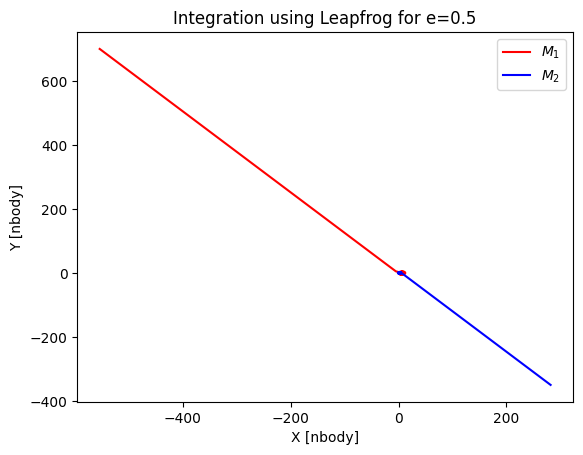

In [135]:
#plt.subplot(1,3,1)
plt.title('Integration using Leapfrog for e=0.5')
plt.plot(path1_leapfrog_1_tsunami[:,0], path1_leapfrog_1_tsunami[:,1], label=f'$M_1$', color='red')
plt.plot(path2_leapfrog_1_tsunami[:,0], path2_leapfrog_1_tsunami[:,1], label=f'$M_2$', color='blue')
plt.xlabel('X [nbody]')
plt.ylabel('Y [nbody]')
plt.legend()